# Task 2 - Applying LDA to **Wine Quality (White) with class balancing** and **binary binning** (Good vs Bad)

This notebook is an *improved* and *task-compliant* version of the Lecture 2 application:

✅ **We still MUST use LDA** (as required).  
✅ We introduce **class balancing** to handle imbalance.  
✅ We also test an **alternative binning**: **Good vs Bad** (binary).

## What we will compare
We evaluate two targets:

1) **3-class target (`quality3`)**  
- 1 = low (≤ 4)  
- 2 = medium (5–6)  
- 3 = high (≥ 7)

2) **Binary target (`good`)**  
- 0 = bad (quality < 7)  
- 1 = good (quality ≥ 7)

And for each target we compare:

- **Default LDA** vs **Balanced LDA** (via equal class priors)
- **Default LDA→LogReg** vs **Balanced LDA→LogReg** (`class_weight="balanced"`)

> Note: `LinearDiscriminantAnalysis` in scikit-learn does not have `class_weight`, so balancing for LDA is done via **equal priors** (`priors=...`).


## 0) Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, balanced_accuracy_score
)

## 1) Load the dataset

The white wine dataset is typically **semicolon-separated** (`sep=";"`).

Adjust the path candidates if your repo structure differs.


In [2]:
candidates = [
    Path("../../../datasets/raw/HW1/winequality-white.csv"),   # your working path
    Path("../datasets/raw/winequality-white.csv"),
    Path("../datasets/raw/Topic2/winequality-white.csv"),
    Path("winequality-white.csv"),
]

data_path = next((p for p in candidates if p.exists()), None)
if data_path is None:
    raise FileNotFoundError("winequality-white.csv not found in expected locations.")

df = pd.read_csv(data_path, sep=";")
print("Loaded from:", data_path.resolve())
print("Shape:", df.shape)
df.head()

Loaded from: F:\PyCharm Projects\Masters-Degree-Business-Analytics\Semester-II\Data-Dimensionality-Reduction-Models\datasets\raw\HW1\winequality-white.csv
Shape: (4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## 2) Quick data checks (missing values + quality distribution)

Total missing values: 0

Quality distribution (counts):


quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64

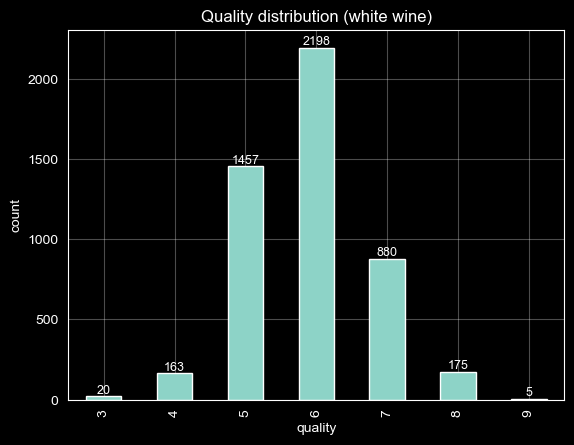

In [3]:
print("Total missing values:", df.isna().sum().sum())

counts_q = df["quality"].value_counts().sort_index()
print("\nQuality distribution (counts):")
display(counts_q)

ax = counts_q.plot(kind="bar")
plt.xlabel("quality")
plt.ylabel("count")
plt.title("Quality distribution (white wine)")
plt.grid(True, alpha=0.3)

for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width()/2, p.get_height()),
        ha="center", va="bottom", fontsize=9
    )

plt.show()

## 3) Create two targets: 3-class and binary (Good vs Bad)

### A) 3-class target (`quality3`)
- 1 (low): quality ≤ 4  
- 2 (medium): quality 5–6  
- 3 (high): quality ≥ 7  

### B) Binary target (`good`)
- 0 (bad): quality < 7  
- 1 (good): quality ≥ 7  

Binary binning is often useful in business settings where we want a “good quality” flag.


Class counts (quality3):


quality3
1     183
2    3655
3    1060
Name: count, dtype: int64


Class counts (good):


good
0    3838
1    1060
Name: count, dtype: int64

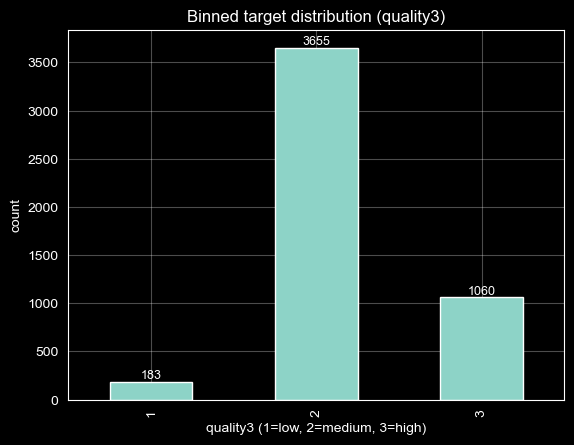

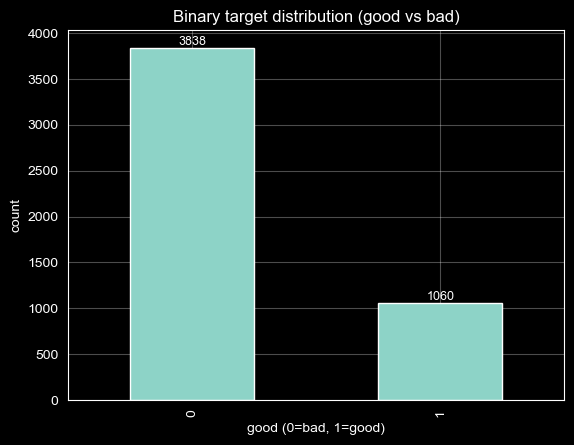

In [4]:
# 3-class
df["quality3"] = np.where(
    df["quality"] <= 4, 1,
    np.where(df["quality"] <= 6, 2, 3)
)

# binary: good vs bad
df["good"] = (df["quality"] >= 7).astype(int)

print("Class counts (quality3):")
counts3 = df["quality3"].value_counts().sort_index()
display(counts3)

print("\nClass counts (good):")
counts_bin = df["good"].value_counts().sort_index()
display(counts_bin)

# plots with labels
ax = counts3.plot(kind="bar")
plt.xlabel("quality3 (1=low, 2=medium, 3=high)")
plt.ylabel("count")
plt.title("Binned target distribution (quality3)")
plt.grid(True, alpha=0.3)
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9)
plt.show()

ax = counts_bin.plot(kind="bar")
plt.xlabel("good (0=bad, 1=good)")
plt.ylabel("count")
plt.title("Binary target distribution (good vs bad)")
plt.grid(True, alpha=0.3)
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9)
plt.show()

## 4) Prepare feature matrix X

We remove the targets (`quality`, `quality3`, `good`) from X.


In [5]:
X = df.drop(columns=["quality", "quality3", "good"])
print("X shape:", X.shape)
X.head()

X shape: (4898, 11)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


## 5) Helper: evaluation on a test split + cross-validation

We report:
- **Accuracy** (overall correctness)
- **Balanced accuracy** (average recall across classes; helps with imbalance)
- **Macro F1** for multiclass (equal weight to each class)
- **F1** for binary (positive-class focus; good for imbalanced binary problems)


In [6]:
def eval_holdout(pipe, X, y, labels=None, average_f1="macro", title="Model"):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y
    )
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, pred)
    bacc = balanced_accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average=average_f1)

    print(f"=== {title} (test split) ===")
    print(f"Accuracy         : {acc:.4f}")
    print(f"Balanced accuracy: {bacc:.4f}")
    print(f"F1 ({average_f1})      : {f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, pred, digits=4))

    if labels is None:
        labels = np.unique(y)
    cm = confusion_matrix(y_test, pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=[f"Actual {l}" for l in labels], columns=[f"Pred {l}" for l in labels])
    print("Confusion matrix:")
    display(cm_df)

    return acc, bacc, f1

def eval_cv(pipe, X, y, scoring_list, cv):
    out = {}
    for s in scoring_list:
        scores = cross_val_score(pipe, X, y, scoring=s, cv=cv, n_jobs=-1)
        out[s] = (scores.mean(), scores.std())
    return out

## 6) Models to compare (Default vs Balanced)

### How we “balance” LDA
`LinearDiscriminantAnalysis` doesn't have `class_weight`.  
Instead, we can set **equal class priors**:

- multiclass with 3 classes → priors = [1/3, 1/3, 1/3]
- binary → priors = [0.5, 0.5]

This forces LDA to treat each class as equally likely *a priori*.

### How we balance Logistic Regression
LogReg supports:
- `class_weight="balanced"`

This rescales the loss so minority classes matter more.


In [7]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# --- 3-class (C=3 => LDA components <= 2)
lda_default_3 = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())
])

lda_balanced_3 = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis(priors=[1/3, 1/3, 1/3]))
])

lda_logreg_default_3 = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis(n_components=2)),
    ("logreg", LogisticRegression(max_iter=5000))
])

lda_logreg_balanced_3 = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis(n_components=2, priors=[1/3, 1/3, 1/3])),
    ("logreg", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

# --- binary good/bad (C=2 => LDA components <= 1)
lda_default_bin = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())
])

lda_balanced_bin = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis(priors=[0.5, 0.5]))
])

lda_logreg_default_bin = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis(n_components=1)),
    ("logreg", LogisticRegression(max_iter=5000))
])

lda_logreg_balanced_bin = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis(n_components=1, priors=[0.5, 0.5])),
    ("logreg", LogisticRegression(max_iter=5000, class_weight="balanced"))
])


## 7) Results — 3-class target (`quality3`)

We compare default vs balanced in two modes:
- LDA classifier
- LDA→LogReg pipeline

For CV we report:
- `accuracy`
- `balanced_accuracy`
- `f1_macro`


In [8]:
y3 = df["quality3"].to_numpy()

# Holdout
_ = eval_holdout(lda_default_3, X, y3, labels=[1,2,3], average_f1="macro", title="LDA (default)")
_ = eval_holdout(lda_balanced_3, X, y3, labels=[1,2,3], average_f1="macro", title="LDA (balanced priors)")
_ = eval_holdout(lda_logreg_default_3, X, y3, labels=[1,2,3], average_f1="macro", title="LDA(2)→LogReg (default)")
_ = eval_holdout(lda_logreg_balanced_3, X, y3, labels=[1,2,3], average_f1="macro", title="LDA(2, balanced)→LogReg(class_weight=balanced)")

# CV summary table
models_3 = {
    "LDA default": lda_default_3,
    "LDA balanced priors": lda_balanced_3,
    "LDA→LogReg default": lda_logreg_default_3,
    "LDA→LogReg balanced": lda_logreg_balanced_3,
}

rows = []
for name, pipe in models_3.items():
    res = eval_cv(pipe, X, y3, ["accuracy", "balanced_accuracy", "f1_macro"], cv=cv)
    rows.append({
        "model": name,
        "cv_accuracy_mean": res["accuracy"][0],
        "cv_accuracy_std": res["accuracy"][1],
        "cv_bal_acc_mean": res["balanced_accuracy"][0],
        "cv_bal_acc_std": res["balanced_accuracy"][1],
        "cv_f1_macro_mean": res["f1_macro"][0],
        "cv_f1_macro_std": res["f1_macro"][1],
    })

cv_df_3 = pd.DataFrame(rows).sort_values("cv_f1_macro_mean", ascending=False)
cv_df_3

=== LDA (default) (test split) ===
Accuracy         : 0.7612
Balanced accuracy: 0.4700
F1 (macro)      : 0.4983

Classification report:
              precision    recall  f1-score   support

           1     0.3462    0.1636    0.2222        55
           2     0.7957    0.9161    0.8517      1097
           3     0.5801    0.3302    0.4208       318

    accuracy                         0.7612      1470
   macro avg     0.5740    0.4700    0.4983      1470
weighted avg     0.7323    0.7612    0.7349      1470

Confusion matrix:


,Pred 1,Pred 2,Pred 3
Actual 1,9,45,1
Actual 2,17,1005,75
Actual 3,0,213,105


=== LDA (balanced priors) (test split) ===
Accuracy         : 0.5803
Balanced accuracy: 0.6217
F1 (macro)      : 0.4727

Classification report:
              precision    recall  f1-score   support

           1     0.1405    0.6182    0.2290        55
           2     0.8623    0.5424    0.6659      1097
           3     0.4164    0.7044    0.5234       318

    accuracy                         0.5803      1470
   macro avg     0.4731    0.6217    0.4727      1470
weighted avg     0.7388    0.5803    0.6187      1470

Confusion matrix:


,Pred 1,Pred 2,Pred 3
Actual 1,34,17,4
Actual 2,192,595,310
Actual 3,16,78,224


=== LDA(2)→LogReg (default) (test split) ===
Accuracy         : 0.7646
Balanced accuracy: 0.4353
F1 (macro)      : 0.4590

Classification report:
              precision    recall  f1-score   support

           1     0.5000    0.0727    0.1270        55
           2     0.7897    0.9344    0.8559      1097
           3     0.5793    0.2987    0.3942       318

    accuracy                         0.7646      1470
   macro avg     0.6230    0.4353    0.4590      1470
weighted avg     0.7333    0.7646    0.7288      1470

Confusion matrix:


,Pred 1,Pred 2,Pred 3
Actual 1,4,50,1
Actual 2,4,1025,68
Actual 3,0,223,95


=== LDA(2, balanced)→LogReg(class_weight=balanced) (test split) ===
Accuracy         : 0.5429
Balanced accuracy: 0.6122
F1 (macro)      : 0.4482

Classification report:
              precision    recall  f1-score   support

           1     0.1203    0.6364    0.2023        55
           2     0.8578    0.4895    0.6233      1097
           3     0.4087    0.7107    0.5189       318

    accuracy                         0.5429      1470
   macro avg     0.4623    0.6122    0.4482      1470
weighted avg     0.7331    0.5429    0.5850      1470

Confusion matrix:


,Pred 1,Pred 2,Pred 3
Actual 1,35,16,4
Actual 2,237,537,323
Actual 3,19,73,226


,model,cv_accuracy_mean,cv_accuracy_std,cv_bal_acc_mean,cv_bal_acc_std,cv_f1_macro_mean,cv_f1_macro_std
0,LDA default,0.760854,0.011453,0.473205,0.028614,0.502464,0.036673
1,LDA balanced priors,0.577377,0.022404,0.624285,0.037069,0.471718,0.018274
3,LDA→LogReg balanced,0.545186,0.024585,0.623333,0.039972,0.452376,0.018694
2,LDA→LogReg default,0.764937,0.011657,0.429734,0.021177,0.450072,0.031393


## 7.5) Visualization — LDA class separation (quality3)

Now that we have numeric results, we visualize **how well the classes separate** in the LDA space.

With **3 classes**, LDA can produce at most:

$$
n_{\text{components}} \le C - 1 = 2
$$

So we can plot the data in **LD1 vs LD2**.

We compare:
- **Default priors** (uses observed class proportions)
- **Balanced priors** (forces equal class importance)


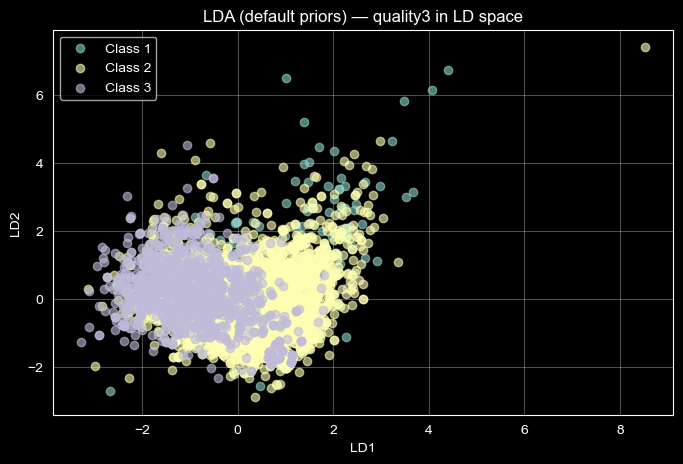

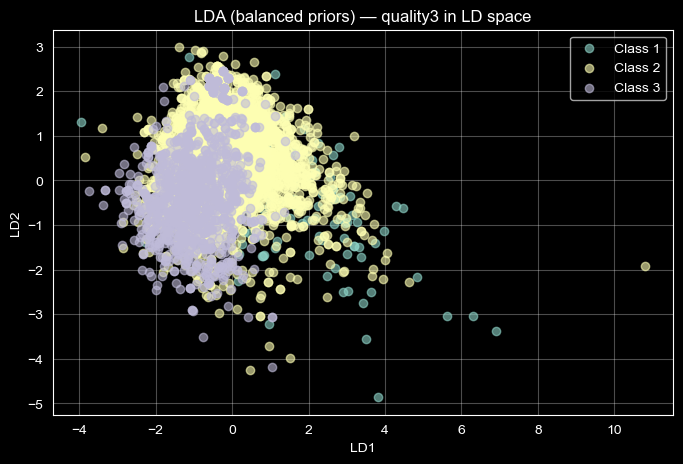

In [9]:
# LDA 2D visualization for quality3 (default vs balanced priors)

# (Re)compute scaled features for visualization
X_scaled = StandardScaler().fit_transform(X)

# Default priors
lda_default_vis = LinearDiscriminantAnalysis(n_components=2)
Z_default = lda_default_vis.fit(X_scaled, y3).transform(X_scaled)

plt.figure(figsize=(8, 5))
for cls in sorted(np.unique(y3)):
    mask = (y3 == cls)
    plt.scatter(Z_default[mask, 0], Z_default[mask, 1], alpha=0.6, label=f"Class {cls}")
plt.title("LDA (default priors) — quality3 in LD space")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Balanced priors (equal class importance)
lda_balanced_vis = LinearDiscriminantAnalysis(n_components=2, priors=[1/3, 1/3, 1/3])
Z_balanced = lda_balanced_vis.fit(X_scaled, y3).transform(X_scaled)

plt.figure(figsize=(8, 5))
for cls in sorted(np.unique(y3)):
    mask = (y3 == cls)
    plt.scatter(Z_balanced[mask, 0], Z_balanced[mask, 1], alpha=0.6, label=f"Class {cls}")
plt.title("LDA (balanced priors) — quality3 in LD space")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 8) Results — Binary target (`good` vs `bad`)

Binary is often easier to model and aligns with many business definitions of “quality”.

For CV we report:
- `accuracy`
- `balanced_accuracy`
- `f1` (positive class = good wine)


In [10]:
ybin = df["good"].to_numpy()

# Holdout
_ = eval_holdout(lda_default_bin, X, ybin, labels=[0,1], average_f1="binary", title="LDA (default) — binary")
_ = eval_holdout(lda_balanced_bin, X, ybin, labels=[0,1], average_f1="binary", title="LDA (balanced priors) — binary")
_ = eval_holdout(lda_logreg_default_bin, X, ybin, labels=[0,1], average_f1="binary", title="LDA(1)→LogReg (default) — binary")
_ = eval_holdout(lda_logreg_balanced_bin, X, ybin, labels=[0,1], average_f1="binary", title="LDA(1, balanced)→LogReg(class_weight=balanced) — binary")

# CV summary table
models_bin = {
    "LDA default (bin)": lda_default_bin,
    "LDA balanced priors (bin)": lda_balanced_bin,
    "LDA→LogReg default (bin)": lda_logreg_default_bin,
    "LDA→LogReg balanced (bin)": lda_logreg_balanced_bin,
}

rows = []
for name, pipe in models_bin.items():
    res = eval_cv(pipe, X, ybin, ["accuracy", "balanced_accuracy", "f1"], cv=cv)
    rows.append({
        "model": name,
        "cv_accuracy_mean": res["accuracy"][0],
        "cv_accuracy_std": res["accuracy"][1],
        "cv_bal_acc_mean": res["balanced_accuracy"][0],
        "cv_bal_acc_std": res["balanced_accuracy"][1],
        "cv_f1_mean": res["f1"][0],
        "cv_f1_std": res["f1"][1],
    })

cv_df_bin = pd.DataFrame(rows).sort_values("cv_f1_mean", ascending=False)
cv_df_bin

=== LDA (default) — binary (test split) ===
Accuracy         : 0.8000
Balanced accuracy: 0.6231
F1 (binary)      : 0.4024

Classification report:
              precision    recall  f1-score   support

           0     0.8310    0.9349    0.8799      1152
           1     0.5690    0.3113    0.4024       318

    accuracy                         0.8000      1470
   macro avg     0.7000    0.6231    0.6412      1470
weighted avg     0.7743    0.8000    0.7766      1470

Confusion matrix:


,Pred 0,Pred 1
Actual 0,1077,75
Actual 1,219,99


=== LDA (balanced priors) — binary (test split) ===
Accuracy         : 0.7184
Balanced accuracy: 0.7201
F1 (binary)      : 0.5263

Classification report:
              precision    recall  f1-score   support

           0     0.9037    0.7170    0.7996      1152
           1     0.4137    0.7233    0.5263       318

    accuracy                         0.7184      1470
   macro avg     0.6587    0.7201    0.6630      1470
weighted avg     0.7977    0.7184    0.7405      1470

Confusion matrix:


,Pred 0,Pred 1
Actual 0,826,326
Actual 1,88,230


=== LDA(1)→LogReg (default) — binary (test split) ===
Accuracy         : 0.8020
Balanced accuracy: 0.6199
F1 (binary)      : 0.3950

Classification report:
              precision    recall  f1-score   support

           0     0.8294    0.9410    0.8817      1152
           1     0.5828    0.2987    0.3950       318

    accuracy                         0.8020      1470
   macro avg     0.7061    0.6199    0.6383      1470
weighted avg     0.7760    0.8020    0.7764      1470

Confusion matrix:


,Pred 0,Pred 1
Actual 0,1084,68
Actual 1,223,95


=== LDA(1, balanced)→LogReg(class_weight=balanced) — binary (test split) ===
Accuracy         : 0.7204
Balanced accuracy: 0.7214
F1 (binary)      : 0.5281

Classification report:
              precision    recall  f1-score   support

           0     0.9040    0.7196    0.8014      1152
           1     0.4159    0.7233    0.5281       318

    accuracy                         0.7204      1470
   macro avg     0.6600    0.7214    0.6647      1470
weighted avg     0.7984    0.7204    0.7422      1470

Confusion matrix:


,Pred 0,Pred 1
Actual 0,829,323
Actual 1,88,230


,model,cv_accuracy_mean,cv_accuracy_std,cv_bal_acc_mean,cv_bal_acc_std,cv_f1_mean,cv_f1_std
3,LDA→LogReg balanced (bin),0.720425,0.024607,0.726690,0.027130,0.533625,0.031807
1,LDA balanced priors (bin),0.719812,0.024497,0.726299,0.027094,0.533070,0.031689
0,LDA default (bin),0.801551,0.011716,0.624019,0.020462,0.403388,0.042736
2,LDA→LogReg default (bin),0.803593,0.011298,0.617697,0.019541,0.389055,0.043080


## 8.5) Visualization — LDA class separation (good vs bad)

For the binary target (**good vs bad**), we have **C = 2**, so LDA can only produce **one** discriminant axis:

$$
n_{\text{components}} \le C - 1 = 1
$$

A clean way to see “class distinction” is to plot the **distribution of LD1 scores** for:
- bad (0)
- good (1)

Less overlap ⇒ easier classification.


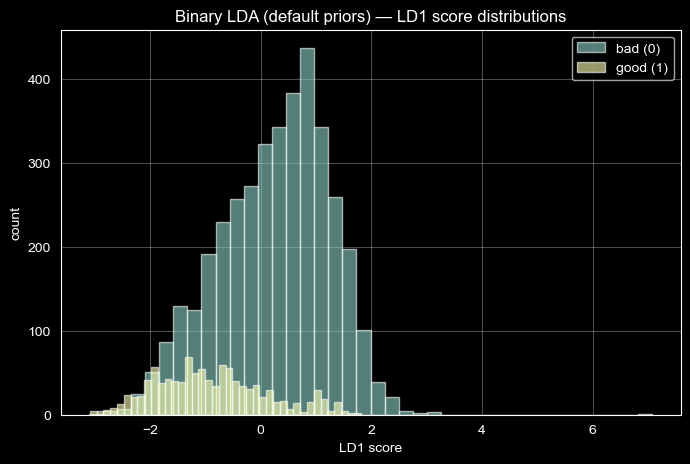

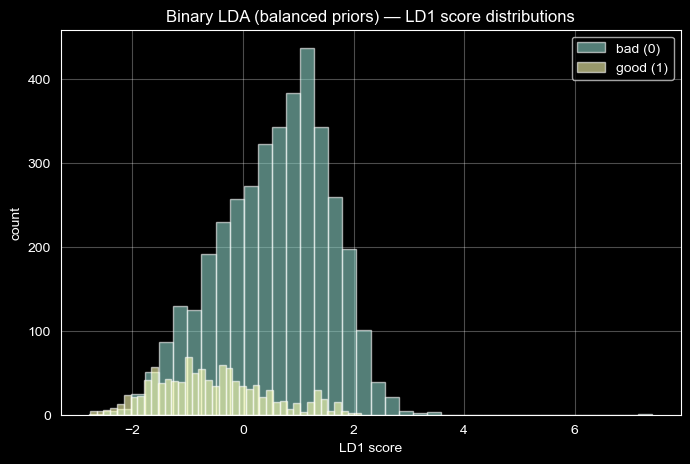

In [11]:
# LDA 1D visualization for binary good/bad (default vs balanced priors)

X_scaled = StandardScaler().fit_transform(X)

# Default priors
lda1_default = LinearDiscriminantAnalysis(n_components=1)
ld1_default = lda1_default.fit(X_scaled, ybin).transform(X_scaled).ravel()

plt.figure(figsize=(8, 5))
plt.hist(ld1_default[ybin == 0], bins=40, alpha=0.6, label="bad (0)")
plt.hist(ld1_default[ybin == 1], bins=40, alpha=0.6, label="good (1)")
plt.title("Binary LDA (default priors) — LD1 score distributions")
plt.xlabel("LD1 score")
plt.ylabel("count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Balanced priors
lda1_balanced = LinearDiscriminantAnalysis(n_components=1, priors=[0.5, 0.5])
ld1_balanced = lda1_balanced.fit(X_scaled, ybin).transform(X_scaled).ravel()

plt.figure(figsize=(8, 5))
plt.hist(ld1_balanced[ybin == 0], bins=40, alpha=0.6, label="bad (0)")
plt.hist(ld1_balanced[ybin == 1], bins=40, alpha=0.6, label="good (1)")
plt.title("Binary LDA (balanced priors) — LD1 score distributions")
plt.xlabel("LD1 score")
plt.ylabel("count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 9) Interpretation guide (what “improvement” should look like)

### For imbalanced problems, prioritize:
- **Balanced accuracy** (are we recalling minority classes?)
- **Macro F1** (multiclass)
- **F1** (binary, positive class = good)

### Expected effect of balancing
- Accuracy might stay similar (because the majority class is easy).
- Balanced metrics (balanced accuracy / macro F1 / F1) should improve if minority classes get better recall.

### Expected effect of binary binning
Binary tasks usually have:
- clearer decision boundary
- higher stability
- easier interpretation (good vs not-good)
